In [1]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [3]:
def load_wav_16k_mono(filename):
    # Load the audio file
    waveform, sample_rate = librosa.load(filename, sr=None, mono=True)

    # Resample to 16kHz if the sample rate is different
    if sample_rate != 16000:
        waveform = librosa.resample(waveform, orig_sr=sample_rate, target_sr=16000)

    return waveform

In [4]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

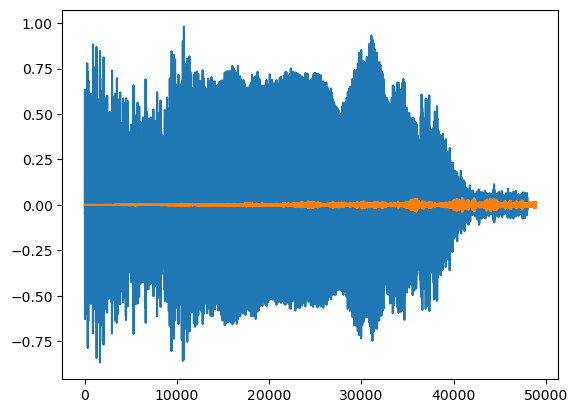

In [5]:
# Plot the waveforms
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [6]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

In [7]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [8]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [9]:
lengths = []
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [10]:
tf.math.reduce_mean(lengths)
tf.math.reduce_min(lengths)
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [11]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [12]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [13]:
spectrogram, label = preprocess(filepath, label)

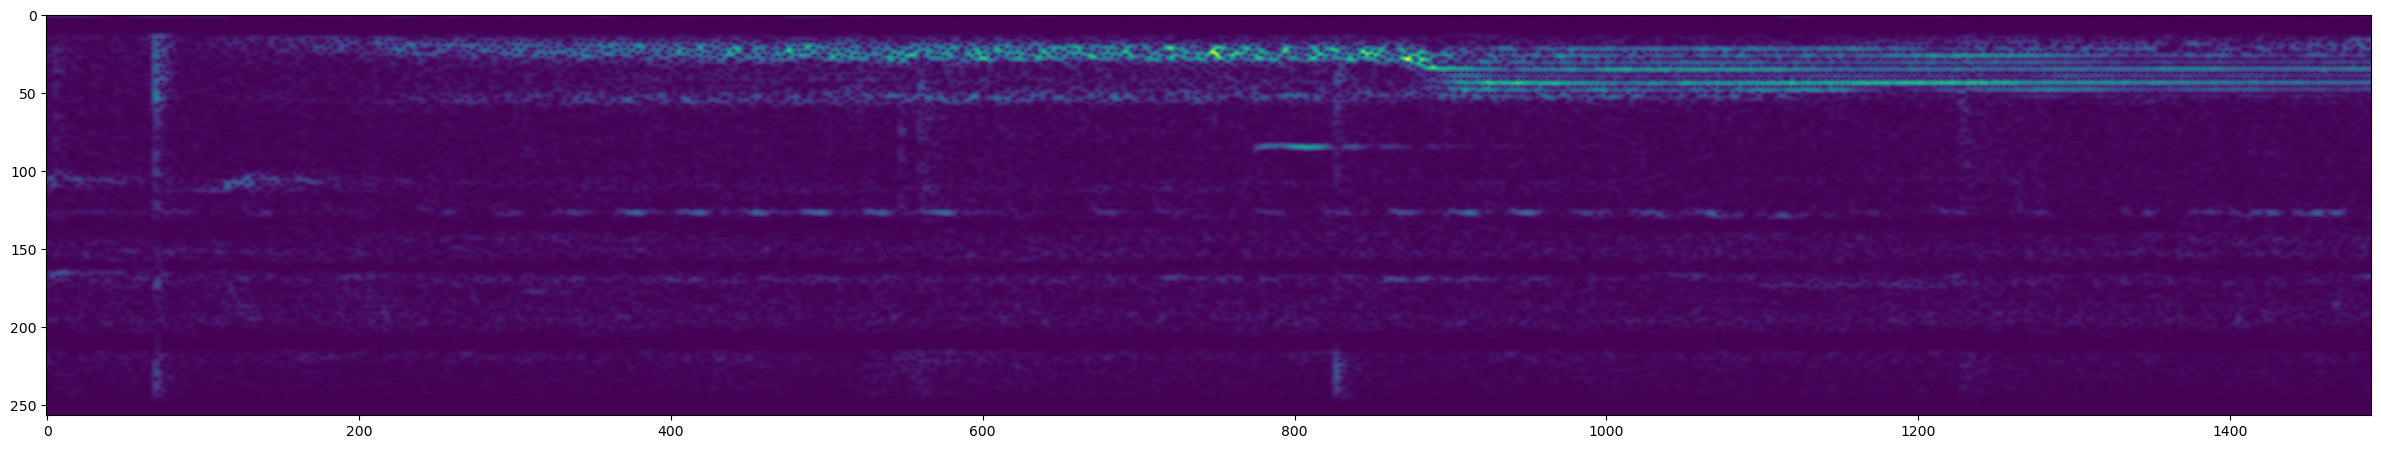

In [14]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [15]:
# Map the preprocessing function to the dataset
data = data.map(lambda x, y: tuple(tf.py_function(preprocess, [x, y], [tf.float32, tf.float32])))

# Cache, shuffle, batch, and prefetch
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)


In [16]:
train = data.take(36)
test = data.skip(36).take(15)

In [17]:
train_iterator = iter(train)
samples, labels = next(train_iterator)

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} TypeError: Invalid file: <tf.Tensor: shape=(), dtype=string, numpy=b'data\\Parsed_Capuchinbird_Clips\\XC227469-2.wav'>
Traceback (most recent call last):

  File "C:\Users\Mann\anaconda3\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 268, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\Mann\anaconda3\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 146, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\Mann\anaconda3\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 153, in _call
    ret = self._func(*args)
          ^^^^^^^^^^^^^^^^^

  File "C:\Users\Mann\anaconda3\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\Mann\AppData\Local\Temp\ipykernel_24636\3763039504.py", line 2, in preprocess
    wav = load_wav_16k_mono(file_path)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\Mann\AppData\Local\Temp\ipykernel_24636\1247614055.py", line 3, in load_wav_16k_mono
    waveform, sample_rate = librosa.load(filename, sr=None, mono=True)
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\Mann\anaconda3\Lib\site-packages\librosa\core\audio.py", line 175, in load
    y, sr_native = __soundfile_load(path, offset, duration, dtype)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\Mann\anaconda3\Lib\site-packages\librosa\core\audio.py", line 208, in __soundfile_load
    context = sf.SoundFile(path)
              ^^^^^^^^^^^^^^^^^^

  File "C:\Users\Mann\anaconda3\Lib\site-packages\soundfile.py", line 658, in __init__
    self._file = self._open(file, mode_int, closefd)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\Mann\anaconda3\Lib\site-packages\soundfile.py", line 1212, in _open
    raise TypeError("Invalid file: {0!r}".format(self.name))

TypeError: Invalid file: <tf.Tensor: shape=(), dtype=string, numpy=b'data\\Parsed_Capuchinbird_Clips\\XC227469-2.wav'>


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 

In [ ]:
samples.shape

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
model.summary()

In [ ]:
hist = model.fit(train, epochs=4, validation_data=test)

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
yhat = model.predict(X_test)

In [ ]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [ ]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [ ]:
wav = load_mp3_16k_mono(mp3)

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

In [ ]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [ ]:
from itertools import groupby

In [ ]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [ ]:
calls

In [ ]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

In [ ]:
results

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

In [ ]:
import csv

In [ ]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])